In [29]:
import numpy as np
from create_data import create_input_data
from create_data import create_input_data_all
import matplotlib.pyplot as plt

In [30]:
def sigmoid(x):
    return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))

In [ ]:
class WakeSleepModel:
    def __init__(self):
        super().__init__()
        
        
        self.i_num = 16
        self.j_num = 8
        self.k_num = 1
        
        self.w_r_ij = np.zeros((self.i_num+1, self.j_num))
        self.w_r_jk = np.zeros((self.j_num+1, self.k_num))
        
        self.w_g_singlebias = np.zeros((1, self.k_num))
        
        self.w_g_kj = np.zeros((self.k_num+1, self.j_num))
        self.w_g_ji = np.zeros((self.j_num+1, self.i_num))
        
        self.s_k = np.zeros((self.k_num))
        self.s_j = np.zeros((self.j_num))
        self.s_i = np.zeros((self.i_num))
        
        self.p_k = np.zeros((self.k_num))
        self.p_j = np.zeros((self.j_num))
        self.p_i = np.zeros((self.i_num))
        
        self.lr = 0.1
    def wake_phase(self, input_data):
        self.recognize(input_data)
        self.feedback()
        
        # 重みの更新
        delta_w_g_singlebias = self.s_k - self.p_k
        self.w_g_singlebias += self.lr * delta_w_g_singlebias
        
        # 2,3層生成重みの更新
        # バイアスを追加
        s_k_appended = np.append(self.s_k, 1)
        # 形を整える
        s_k_reshape = s_k_appended.reshape(self.k_num+1,1)
        s_j_reshape = self.s_j.reshape(1,self.j_num)
        p_j_reshape = self.p_j.reshape(1,self.j_num)
        delta_w_g_kj = s_k_reshape @ (s_j_reshape - p_j_reshape)
        self.w_g_kj += self.lr * delta_w_g_kj
        
        # 1,2層生成重みの更新
        # バイアスを追加
        s_j_appended = np.append(self.s_j, 1)
        # 形を整える
        s_j_reshape = s_j_appended.reshape(self.j_num+1,1)
        s_i_reshape = self.s_i.reshape(1,self.i_num)
        p_i_reshape = self.p_i.reshape(1,self.i_num)
        delta_w_g_ji = s_j_reshape @ (s_i_reshape - p_i_reshape)
        self.w_g_ji += self.lr * delta_w_g_ji
        
        
    def recognize(self, input_data):
        self.s_i = input_data
        s_i_appended = np.append(self.s_i, 1)
        tmp_j = sigmoid(s_i_appended @ self.w_r_ij)
        self.s_j = np.random.binomial(1, tmp_j)
        
        s_j_appended = np.append(self.s_j, 1)
        tmp_k = sigmoid(s_j_appended @ self.w_r_jk)
        self.s_k = np.random.binomial(1, tmp_k)
    
    def feedback(self):
        self.p_k = sigmoid(self.w_g_singlebias)
        
        s_k_appended = np.append(self.s_k, 1)
        self.p_j = sigmoid(s_k_appended @ self.w_g_kj)
        
        s_j_appended = np.append(self.s_j, 1)
        self.p_i = sigmoid(s_j_appended @ self.w_g_ji)
    
    def sleep_phase(self):
        self.generate()
        self.feedfoward()
        
        ## 認識重みの更新
        # 1,2層認識重みの更新
        s_i_appended = np.append(self.s_i, 1)
        s_i_reshape = s_i_appended.reshape(self.i_num+1,1)
        s_j_reshape = self.s_j.reshape(1,self.j_num)
        p_j_reshape = self.p_j.reshape(1,self.j_num)
        delta_w_r_ij = s_i_reshape @ (s_j_reshape - p_j_reshape)
        self.w_r_ij += self.lr * delta_w_r_ij

        # 2,3層認識重みの更新
        s_j_appended = np.append(self.s_j, 1)
        s_j_reshape = s_j_appended.reshape(self.j_num+1,1)
        s_k_reshape = self.s_k.reshape(1,self.k_num)
        p_k_reshape = self.p_k.reshape(1,self.k_num)
        delta_w_r_jk = s_j_reshape @ (s_k_reshape - p_k_reshape)
        self.w_r_jk += self.lr * delta_w_r_jk
        
    
    def generate(self):
        tmp_k = sigmoid(self.w_g_singlebias)
        # 確率に従ってサンプリング
        self.s_k = np.random.binomial(1, tmp_k)

        # バイアスを追加
        
        s_k_appended = np.append(self.s_k, 1)
        # 重みづけの和を計算
        tmp_j = sigmoid(s_k_appended @ self.w_g_kj)
        # 確率に従ってサンプリング
        self.s_j = np.random.binomial(1, tmp_j)

        # バイアスを追加
        s_j_appended = np.append(self.s_j, 1)
        tmp_i =sigmoid(s_j_appended @ self.w_g_ji)
        # 確率に従ってサンプリング
        self.s_i = np.random.binomial(1, tmp_i)
    
    def feedfoward(self):
        # バイアスを追加
        s_i_appended = np.append(self.s_i, 1)
        self.p_j = sigmoid(s_i_appended @ self.w_r_ij)

        # バイアスを追加
        s_j_appended = np.append(self.s_j, 1)
        self.p_k = sigmoid(s_j_appended @ self.w_r_jk)

In [ ]:
# 入力dを作成
d_list = create_input_data_all()
for i in range(len(d_list)):
    d = d_list[i]
    image = d.reshape(4,4)
    plt.imshow(image, 'gray')
    plt.show()

In [ ]:
ws = WakeSleepModel()
iter = 500000

for i in range(iter):
    input_data = d_list[np.random.randint(0, len(d_list))]
    ws.wake_phase(input_data)
    ws.sleep_phase()


In [ ]:
for i in range(8):
    image = ws.w_g_ji[i].reshape(4,4)
    plt.imshow(image, 'gray')
    plt.show()

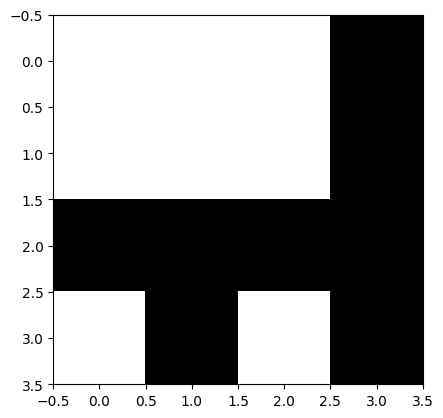

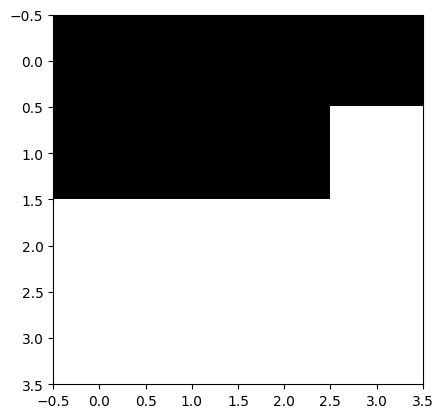

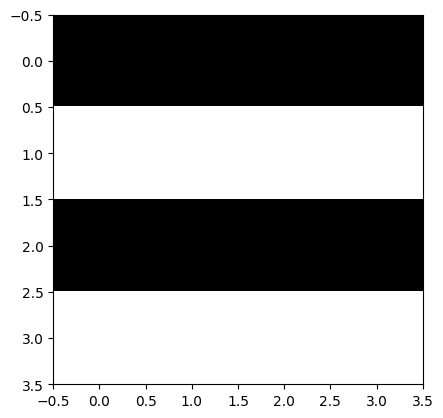

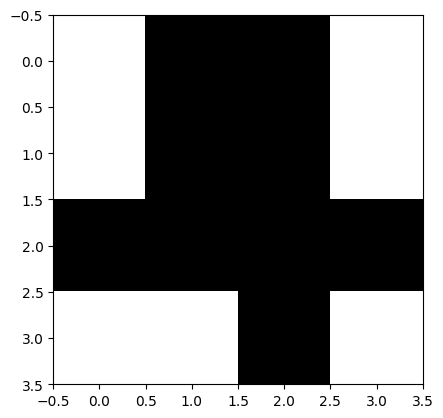

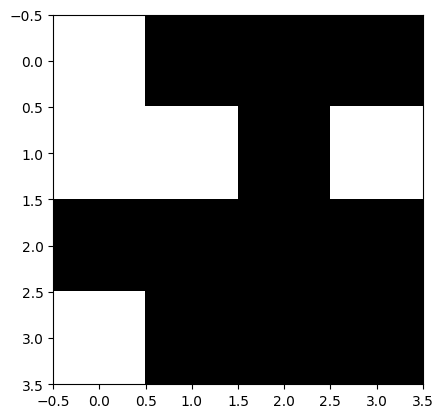

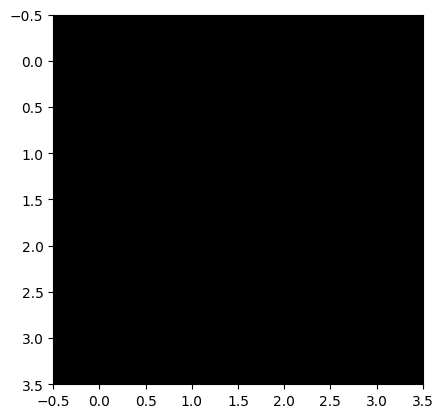

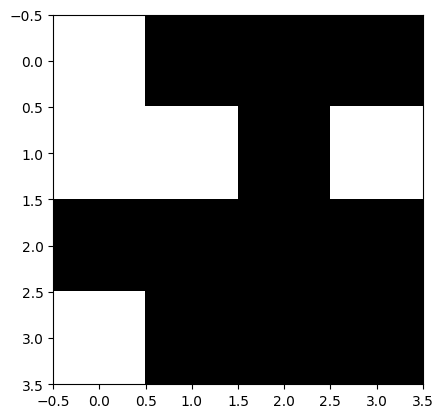

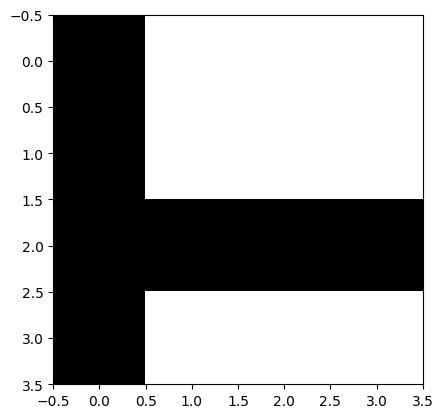

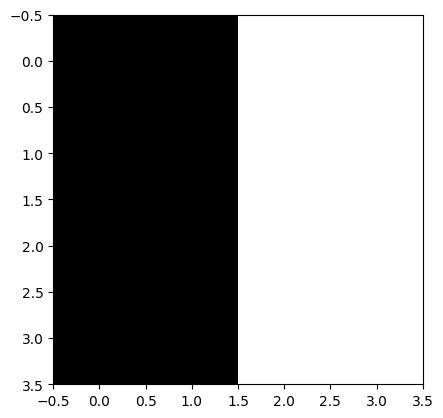

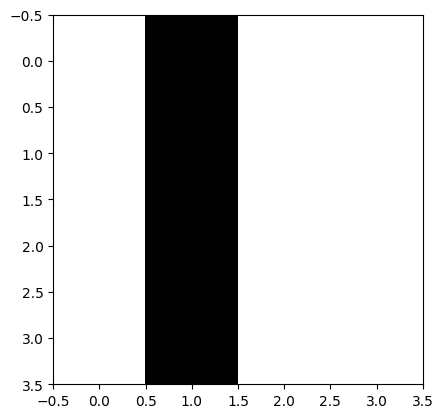

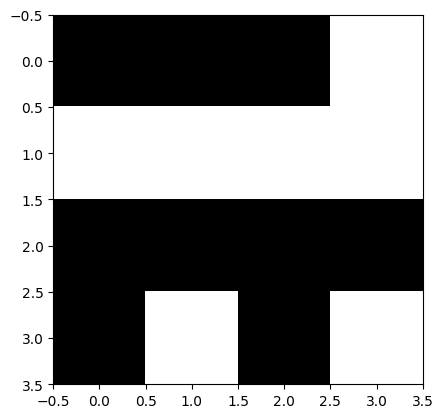

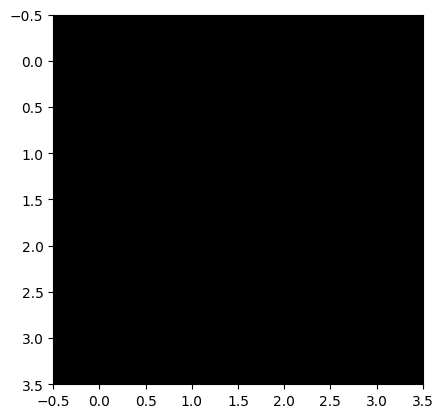

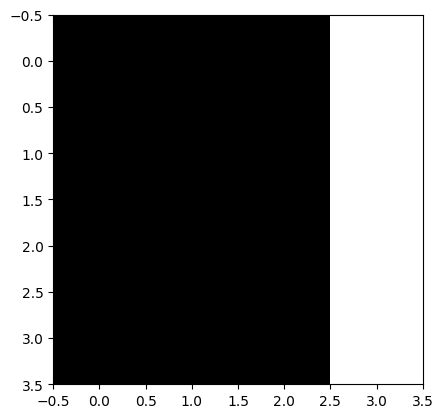

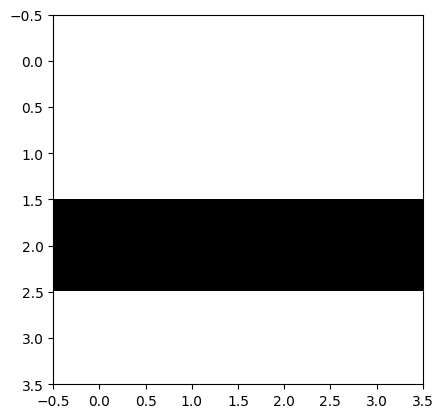

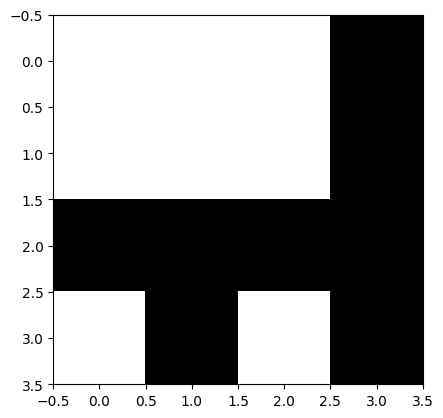

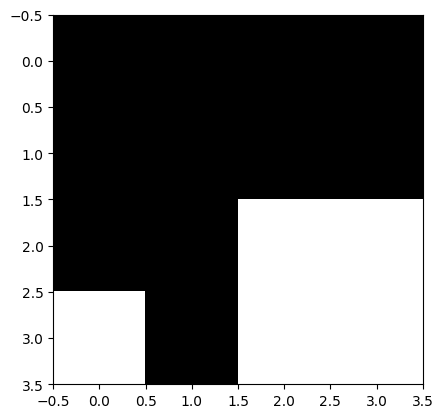

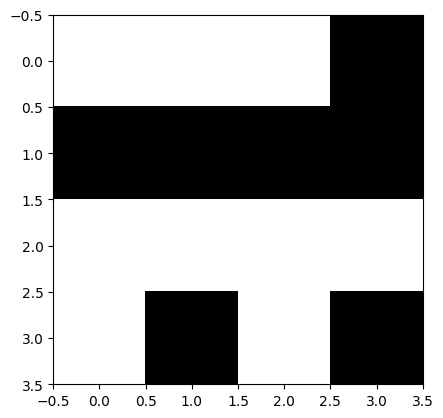

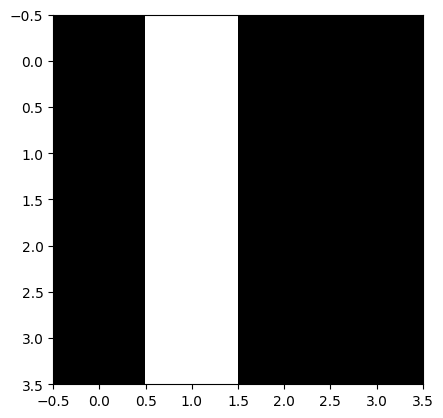

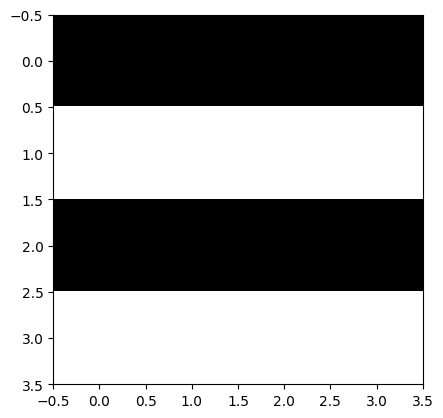

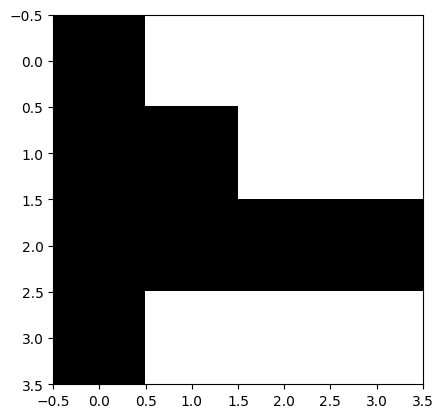

In [41]:
for i in range(20): 
    ws.generate()
    image = ws.s_i.reshape(4,4)
    plt.imshow(image, 'gray')
    plt.show()    

